In [2]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

import dataframe_image as dfi
from scipy.stats import ks_2samp

In [40]:
#DIR_list=['Ravi2/', 'Ravi3/', 'Ravi4/']
#pth_list=['Ravi2_orthomosaic_02mm.png', 'Ravi3_orthomosaic_clip_02mm.tif', 'Ravi4_orthomosaic_clip_02mm.tif']
head='/DATA/vito/data/'
def get_synth_ac(Ds, head):
    return [os.path.join(head+Ds, f) for f in os.listdir(head+Ds) if os.path.isfile(os.path.join(head+Ds, f))]
s02 = get_synth_ac('ran_synth_12_1500_shadow2_0_2/ran_synth_12_1500_shadow2_0_2', head)
s02.sort()
s05 = get_synth_ac('ran_synth_12_1500_shadow2_0_5/ran_synth_12_1500_shadow2_0_5', head)
s05.sort()

In [41]:
s02

['/DATA/vito/data/ran_synth_12_1500_shadow2_0_2/ran_synth_12_1500_shadow2_0_2/point_based_ac_00.npy',
 '/DATA/vito/data/ran_synth_12_1500_shadow2_0_2/ran_synth_12_1500_shadow2_0_2/point_based_ac_01.npy',
 '/DATA/vito/data/ran_synth_12_1500_shadow2_0_2/ran_synth_12_1500_shadow2_0_2/point_based_ac_02.npy',
 '/DATA/vito/data/ran_synth_12_1500_shadow2_0_2/ran_synth_12_1500_shadow2_0_2/point_based_ac_03.npy',
 '/DATA/vito/data/ran_synth_12_1500_shadow2_0_2/ran_synth_12_1500_shadow2_0_2/point_based_ac_04.npy',
 '/DATA/vito/data/ran_synth_12_1500_shadow2_0_2/ran_synth_12_1500_shadow2_0_2/point_based_ac_05.npy',
 '/DATA/vito/data/ran_synth_12_1500_shadow2_0_2/ran_synth_12_1500_shadow2_0_2/point_based_ac_06.npy',
 '/DATA/vito/data/ran_synth_12_1500_shadow2_0_2/ran_synth_12_1500_shadow2_0_2/point_based_ac_07.npy',
 '/DATA/vito/data/ran_synth_12_1500_shadow2_0_2/ran_synth_12_1500_shadow2_0_2/point_based_ac_08.npy',
 '/DATA/vito/data/ran_synth_12_1500_shadow2_0_2/ran_synth_12_1500_shadow2_0_2/poin

In [42]:
def iou_vs_area(DS_pths,c, handles, label):
    for pth in DS_pths:
        ran=np.load(pth, allow_pickle=True)
        iou_bysize = []
        for i in range(len(ran.item().get('iou'))):
            iou = np.mean(np.abs(ran.item().get('iou')[i:]))
            iou_bysize.append(iou)
        iou_bysize = np.array(iou_bysize)
        plt.plot(ran.item().get('area'), iou_bysize,color=c, alpha=0.5)
    handles.append(plt.Line2D([0], [0], color=c, label=label, alpha=0.5))
    return handles

def iou_scatter(DS_pths,c, handles, label):
    for pth in DS_pths:
        ran=np.load(pth, allow_pickle=True)
        plt.scatter(ran.item().get('area'), np.abs(ran.item().get('iou')),color=c, label=f'{pth[-6:-4]}', alpha=0.5)
    handles.append(plt.Line2D([0], [0], marker='o', linestyle='None', color=c, label=label, alpha=0.5))
    return handles

def f1_vs_area(DS_pths,c, handles, label):
    for pth in DS_pths:
        ran=np.load(pth, allow_pickle=True)
        f1_bysize = []

        for i in range(len(ran.item().get('point based'))):
            ac_class, count = np.unique(ran.item().get('point based')[i:], return_counts=True)
            TP_count = count[ac_class == 1][0] if 1 in ac_class else 0
            FN_count = count[ac_class == 0][0] if 0 in ac_class else 0
            if np.any(ac_class > 1):
                TP_count += np.sum(count[ac_class > 1])
                FP_id_count = np.sum(count[ac_class > 1])
                FP_count = np.sum([ac_class[i]*count[i] for i in range(len(ac_class)) if ac_class[i]>1]) - FP_id_count
            else:
                FP_count = 0
            precision = TP_count / (TP_count + FP_count) if (TP_count + FP_count) > 0 else 0
            recall = TP_count / (TP_count + FN_count) if (TP_count + FN_count) > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
            f1_bysize.append(f1)
        f1_bysize = np.array(f1_bysize)
        plt.plot(ran.item().get('area'), f1_bysize,color=c, label=f'{pth[-6:-4]}', alpha=0.5)
    handles.append(plt.Line2D([0], [0], color=c, label=label, alpha=0.5))
    return handles

def f1_scatter(DS_pths,c, handles, label):
    for pth in DS_pths:
        ran=np.load(pth, allow_pickle=True)
        plt.scatter(ran.item().get('area'), ran.item().get('point based'),color=c, label=f'{pth[-6:-4]}', alpha=0.5)
    handles.append(plt.Line2D([0], [0], marker='o', linestyle='None', color=c, label=label, alpha=0.5))
    return handles
def subplot_setup(handles, title, xlabel, ylabel, logx=True):
    ax1 = plt.gca()
    ax2 = ax1.secondary_xaxis('top', functions=(lambda x: (np.sqrt(x / np.pi))/(0.2), lambda x: ((x*0.2)**2) * np.pi))
    ax2.set_xlabel('Radius (pixels)')

    plt.legend(handles=handles, loc='lower right')

    plt.grid()
    if logx:
        plt.xscale('log')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

def Ravis(func, handles):
    handles = func(0, handles, 'Ravi 2','#1f77b4', 200)
    handles = func(1, handles, 'Ravi 3','#ff7f0e', 200)
    handles = func(2, handles, 'Ravi 4','#2ca02c', 200)
    return handles

In [43]:
def ks_DS(DS_pths, threshold=0):
    sizes=[]
    sizes_re=[]
    for pth in DS_pths:
        ran=np.load(pth, allow_pickle=True)
        sizes += list(ran.item().get('area'))
        sizes_re += list(ran.item().get('segment area'))
    
    sizes = np.sort(sizes)/(0.2*0.2)

    sizes_re = np.sort(sizes_re)

    if threshold!=0:
        threshold=np.pi*(threshold/2)**2
        sizes=sizes[sizes>threshold]
        sizes_re=sizes_re[sizes_re>threshold]
    if len(sizes)>0 and len(sizes_re)>0:
        ks=ks_2samp(sizes_re,sizes, method= 'exact', alternative='two-sided')
    else:
        ks=[np.nan,np.nan]
    return ks

In [53]:
mask=np.load('/DATA/vito/data/ran_synth_12_1500_shadow2_0_2/msk.npy')
ids, counts=np.unique(mask, return_counts=True)
ids, counts = ids[1:], counts[1:]
area = counts * (0.2 * 0.2)
ids = ids[np.argsort(area)]
area = np.sort(area)
sdmsk = get_synth_ac('ran_synth_12_1500_shadow2_0_2/shd', head)
sdmsk.sort()
all_shadow_list=[]
for i in range(len(s02)):
    shd_mask=np.load(sdmsk[i])
    shadowed_id,shadowed_area=np.unique(mask[shd_mask<1], return_counts=True)
    shadowed_id, shadowed_area = shadowed_id[1:], shadowed_area[1:] 
    shadowed_area = shadowed_area * (0.2 * 0.2)
    completely_in_shadow=np.zeros_like(ids)
    for i in ids:
        if i in shadowed_id:
            if shadowed_area[shadowed_id==i]/area[ids==i]>0.9:
                completely_in_shadow[ids==i]=1
    all_shadow_list.append(completely_in_shadow)
all_shadow_array = np.vstack(all_shadow_list)

In [44]:
data = []
for syn in [s02]:
    all_positives_T, TP_T, FP_T, FN_T, label_T = 0, 0, 0, 0, 0
    for pth in syn:
        ran=np.load(pth, allow_pickle=True)
        ac_class, count = np.unique(ran.item().get('point based'), return_counts=True)
        TP_count = np.sum(count[ac_class > 0]) if 1 in ac_class else 0
        FN_count = count[ac_class == 0][0] if 0 in ac_class else 0
        FP_count = ran.item().get('mask_count')-1-np.sum(count[ac_class>0])
        Label_count = ran.item().get('label_count')

        TP_T += TP_count
        FN_T += FN_count
        FP_T += FP_count
        label_T += Label_count
        all_positives_T += ran.item().get('mask_count')-1
    ks_test=ks_DS(syn)
    ks_test_25=ks_DS(syn,20)
    ks_test_30=ks_DS(syn,30)
    precision = TP_T / (TP_T + FP_T) if (TP_T + FP_T) > 0 else 0
    recall = TP_T / (TP_T + FN_T) if (TP_T + FN_T) > 0 else 0
    F1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    data.append({
        'Image': syn[0].split('\\')[0],
        'Label count': label_T,
        'SAM Positives': all_positives_T,
        'True Positives': TP_T,
        'False Positives': FP_T,
        'False Negatives': FN_T,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': F1,
        'Ks statistic':np.round(ks_test[0],2),
        'Ks p': np.round(ks_test[1],2),
        'Ks statistic t25':np.round(ks_test_25[0],2),
        'Ks p t25': np.round(ks_test_25[1],2),
        'Ks statistic t30':np.round(ks_test_30[0],2),
        'Ks p t30': np.round(ks_test_30[1],2)
    })

df = pd.DataFrame(data)
df

,Image,Label count,SAM Positives,True Positives,False Positives,False Negatives,Precision,Recall,F1 Score,Ks statistic,Ks p,Ks statistic t25,Ks p t25,Ks statistic t30,Ks p t30
0,/DATA/vito/data/ran_synth_12_1500_shadow2_0_2/...,28020,26777,26004,773,2016,0.971132,0.928051,0.949103,0.04,0.0,0.04,0.0,0.03,0.0


In [58]:
data = []
inclination=[50,60,70,80,50,60,70,80, 50,60,70,80]
azimuth=[0,0,0,0,90,90,90,90, 180,180,180,180]
ss_L=[0.2,0.5]
for ss,syn in enumerate([s02,s05]):
    for i,pth in enumerate(syn):
        all_positives_T, TP_T, FP_T, FN_T, label_T = 0, 0, 0, 0, 0
        ran=np.load(pth, allow_pickle=True)
        ac_class, count = np.unique(ran.item().get('point based'), return_counts=True)
        TP_count = np.sum(count[ac_class > 0]) if 1 in ac_class else 0
        FN_count = count[ac_class == 0][0] if 0 in ac_class else 0
        FP_count = ran.item().get('mask_count')-1-np.sum(count[ac_class>0])
        Label_count = ran.item().get('label_count')
        shadowed_count = np.sum(all_shadow_array[i])

        TP_T += TP_count
        FN_T += FN_count
        FP_T += FP_count
        label_T += Label_count
        all_positives_T += ran.item().get('mask_count')-1
        ks_test=ks_DS(syn)
        ks_test_25=ks_DS(syn,20)
        ks_test_30=ks_DS(syn,30)
        precision = TP_T / (TP_T + FP_T) if (TP_T + FP_T) > 0 else 0
        recall = TP_T / (TP_T + FN_T) if (TP_T + FN_T) > 0 else 0
        F1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        data.append({
            #'Image': pth.split('/')[-1],
            'Inclination': inclination[int(pth[-6:-4])],
            'Azimuth': azimuth[int(pth[-6:-4])],
            'Shadowed_brigntness': ss_L[ss],
            'Label count': label_T,
            'SAM Positives': all_positives_T,
            'In shadow count': shadowed_count,
            'True Positives': TP_T,
            'False Positives': FP_T,
            'False Negatives': FN_T,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': F1,
            'Ks statistic':np.round(ks_test[0],2),
            'Ks p': np.round(ks_test[1],2)
            #'Ks statistic t25':np.round(ks_test_25[0],2),
            #'Ks p t25': np.round(ks_test_25[1],2),
            #'Ks statistic t30':np.round(ks_test_30[0],2),
            #'Ks p t30': np.round(ks_test_30[1],2)
        })

df = pd.DataFrame(data)
df

,Inclination,Azimuth,Shadowed_brigntness,Label count,SAM Positives,In shadow count,True Positives,False Positives,False Negatives,Precision,Recall,F1 Score,Ks statistic,Ks p
0,50,0,0.2,2335,2232,333,2158,74,177,0.966846,0.924197,0.945041,0.04,0.0
1,60,0,0.2,2335,2231,585,2168,63,167,0.971762,0.928480,0.949628,0.04,0.0
2,70,0,0.2,2335,2243,1012,2172,71,163,0.968346,0.930193,0.948886,0.04,0.0
3,80,0,0.2,2335,2233,1614,2171,62,164,0.972235,0.929764,0.950525,0.04,0.0
4,50,90,0.2,2335,2229,348,2176,53,159,0.976223,0.931906,0.953550,0.04,0.0
5,60,90,0.2,2335,2226,669,2169,57,166,0.974394,0.928908,0.951107,0.04,0.0
6,70,90,0.2,2335,2236,1078,2179,57,156,0.974508,0.933191,0.953402,0.04,0.0
7,80,90,0.2,2335,2213,1668,2173,40,162,0.981925,0.930621,0.955585,0.04,0.0
8,50,180,0.2,2335,2227,365,2153,74,182,0.966771,0.922056,0.943884,0.04,0.0
9,60,180,0.2,2335,2230,657,2156,74,179,0.966816,0.923340,0.944578,0.04,0.0


In [32]:
df_styled = df.style.background_gradient().format(precision=2)
df_styled
dfi.export(df_styled, '/DATA/vito/fig/shadow_ac_table.png',table_conversion = 'matplotlib')

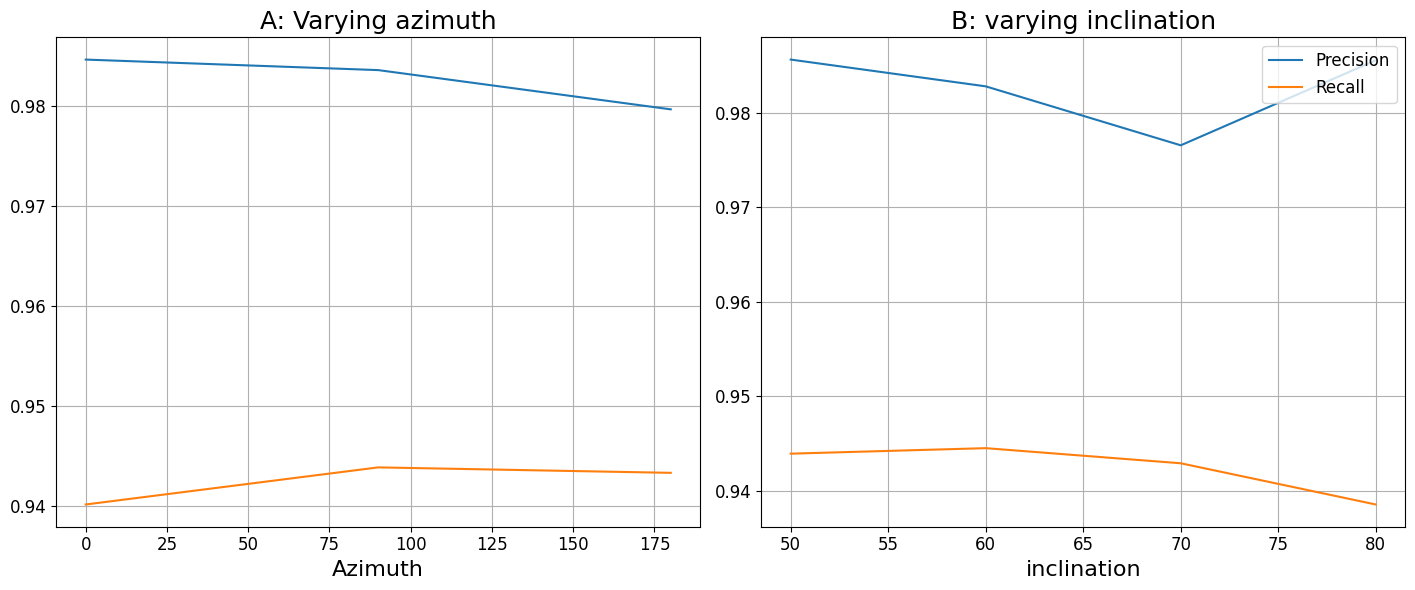

In [10]:
Min_radi=[2,4,8,32,64]
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
precision_L, recall_L = [], []

inclination=[50,60,70,80,50,60,70,80, 50,60,70,80]
azimuth=[0,0,0,0,90,90,90,90, 180,180,180,180]
for syn in [s02]:
    for pth in syn:
        all_positives_T, TP_T, FP_T, FN_T, label_T = 0, 0, 0, 0, 0
        ran=np.load(pth, allow_pickle=True)
        ac_class, count = np.unique(ran.item().get('point based'), return_counts=True)
        TP_count = np.sum(count[ac_class > 0]) if 1 in ac_class else 0
        FN_count = count[ac_class == 0][0] if 0 in ac_class else 0
        FP_count = ran.item().get('mask_count')-1-np.sum(count[ac_class>0])
        Label_count = ran.item().get('label_count')

        TP_T += TP_count
        FN_T += FN_count
        FP_T += FP_count
        label_T += Label_count
        all_positives_T += ran.item().get('mask_count')-1
        precision = TP_T / (TP_T + FP_T) if (TP_T + FP_T) > 0 else 0
        recall = TP_T / (TP_T + FN_T) if (TP_T + FN_T) > 0 else 0
        F1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        precision_L.append(precision)
        recall_L.append(recall)


plt.plot([0,90,180], [sum(precision_L[i:i+4])/4 for i in range(0, len(precision_L), 4)], label='Precision')
plt.plot([0,90,180], [sum(recall_L[i:i+4])/4 for i in range(0, len(recall_L), 4)], label='Recall')

plt.grid()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12) 
#plt.ylabel('Metrics', fontsize=16)
plt.xlabel('Azimuth', fontsize=16)
plt.title('A: Varying azimuth', fontsize=18)

plt.subplot(1, 2, 2)
plt.plot([50,60,70,80], [sum([precision_L[i+n] for i in [0, 4, 8]])/3 for n in range(4)],c='#1f77b4', label='Precision')
plt.plot([50,60,70,80], [sum([recall_L[i+n] for i in [0, 4, 8]])/3 for n in range(4)],c='#ff7f0e', label='Recall')
#plt.xscale('log')
plt.legend(loc='upper right', fontsize=12)
plt.grid()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12) 
plt.xlabel('inclination', fontsize=16)
plt.title('B: varying inclination', fontsize=18)

#plt.gcf().text(0.04, 0.5, 'Metrics', fontsize=16, rotation=90, va='center')
plt.tight_layout(rect=[0.05, 0, 1, 1])
#plt.savefig('figure/ac_pr_synth.png')


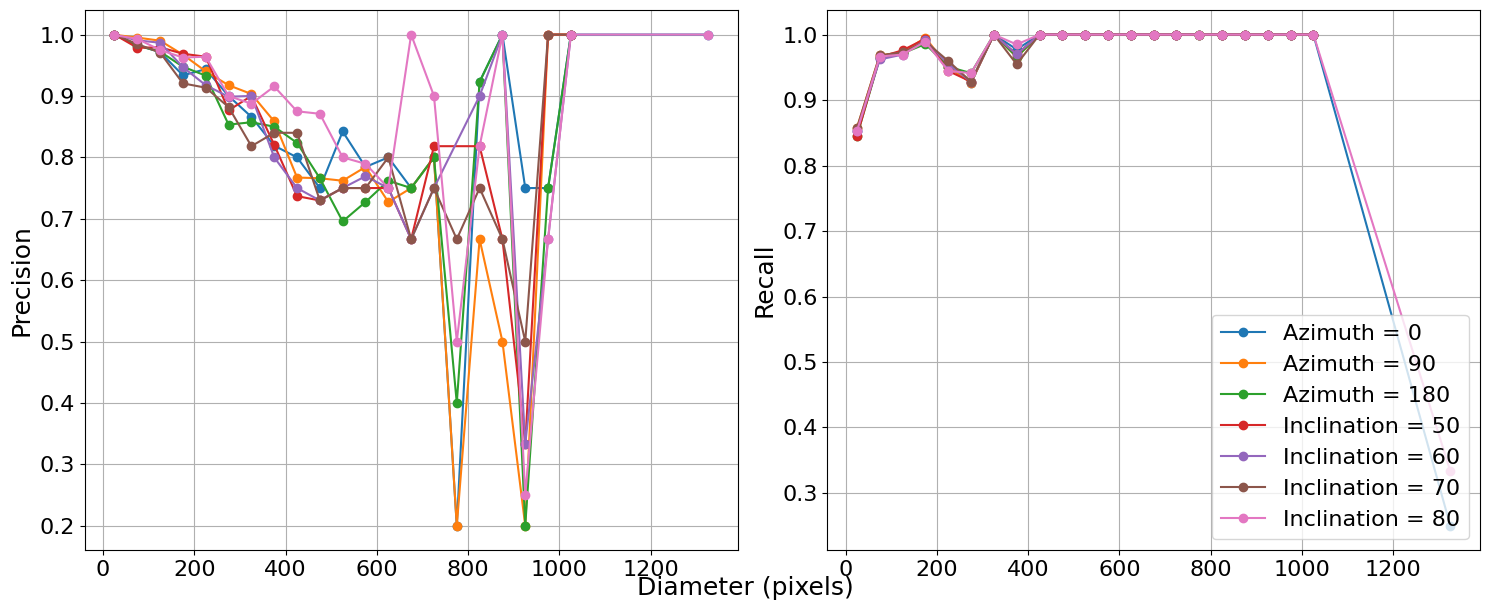

In [60]:
bin_edges = np.arange(0, 1500, 50)  # Bins from 0 to 20 in steps of 2
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

Min_radi=['Azimuth = 0','Azimuth = 90','Azimuth = 180',
          'Inclination = 50','Inclination = 60','Inclination = 70','Inclination = 80']
fig, ax =plt.subplots(1,2,figsize=(15, 6))
precision_L, recall_L = [], []
for l,paths in enumerate([[0,1,2,3],[4,5,6,7],[8,9,10,11],[0,4,8],[1,5,9],[2,6,10],[3,7,11]]):
    precision_binned = []
    recall_binned = []

    for i in range(len(bin_edges) - 1):
        TP_T, FP_T, FN_T = 0, 0, 0  
    
        for path in paths:
            pth = s02[path]
            ran = np.load(pth, allow_pickle=True)
            area = np.array(ran.item().get('area'))
            area = (np.sqrt(area / np.pi) / 0.2) * 2  
            ac = np.array(ran.item().get('point based'))

            mask = (area >= bin_edges[i]) & (area < bin_edges[i + 1])
            ac_bin = ac[mask]
            area_bin = area[mask]

            if len(area_bin) == 0:
                continue 

            ac_class, count = np.unique(ac_bin, return_counts=True)

            TP_count = np.sum(count[ac_class > 0]) if 1 in ac_class else 0
            FN_count = count[ac_class == 0][0] if 0 in ac_class else 0
            multi = 0
            for c in np.where(ac_class > 1)[0]:
                if c < len(ac_class):
                    multi += (count[c] * ac_class[c]).item()
            FP_count = multi - np.sum(count[ac_class > 1])

            TP_T += TP_count
            FN_T += FN_count
            FP_T += FP_count

        precision = TP_T / (TP_T + FP_T) if (TP_T + FP_T) > 0 else 0
        recall = TP_T / (TP_T + FN_T) if (TP_T + FN_T) > 0 else 0

        precision_binned.append(precision)
        recall_binned.append(recall)

    recall_binned = np.array(recall_binned)
    precision_binned = np.array(precision_binned)
    bin_centers = np.array(bin_centers)
    ax[1].plot(bin_centers[recall_binned>0], recall_binned[recall_binned>0], 'o-', label=f'{Min_radi[l]}')
    ax[0].plot(bin_centers[precision_binned>0], precision_binned[precision_binned>0], 'o-', label=f'{Min_radi[l]}')
ax[1].legend(loc='lower right', fontsize=16)
ax[0].grid()
ax[0].tick_params(axis='both', labelsize=16)
ax[1].grid()
ax[1].tick_params(axis='both', labelsize=16)
ax[0].set_ylabel('Precision', fontsize=18)
ax[1].set_ylabel('Recall', fontsize=18)
plt.figtext(0.5, 0.0, 'Diameter (pixels)', ha='center', fontsize=18)
plt.tight_layout()
#plt.savefig('figure\detection_limit.png')
plt.show()

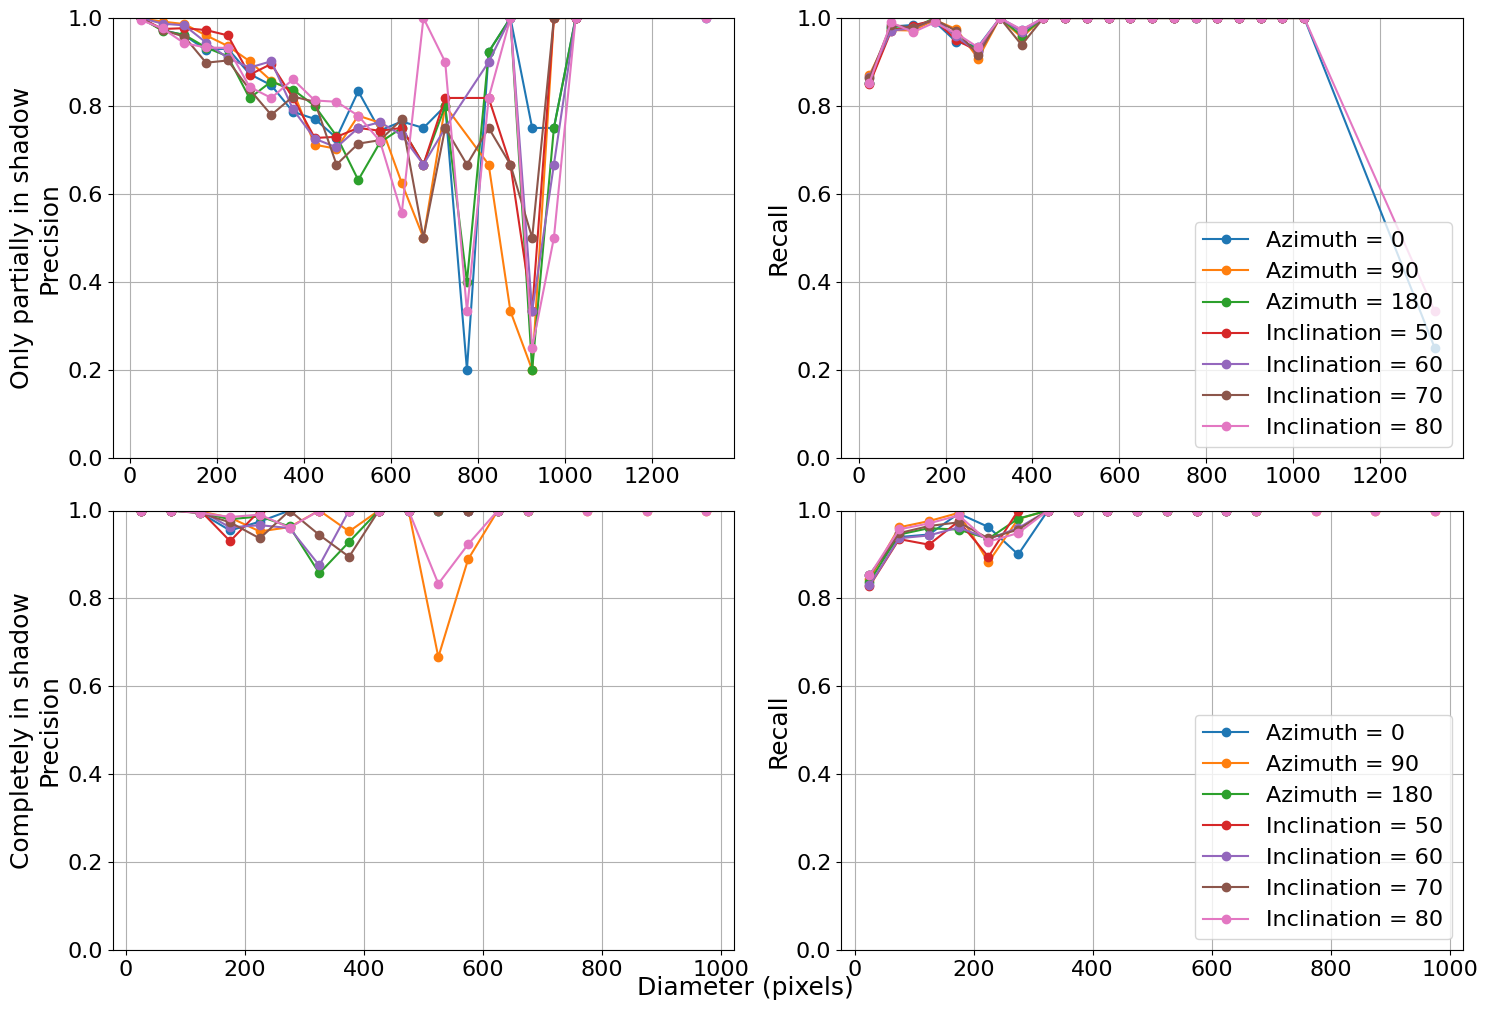

In [69]:
bin_edges = np.arange(0, 1500, 50)  # Bins from 0 to 20 in steps of 2
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

Min_radi=['Azimuth = 0','Azimuth = 90','Azimuth = 180',
          'Inclination = 50','Inclination = 60','Inclination = 70','Inclination = 80']
fig, ax =plt.subplots(2,2,figsize=(15, 10))
ax= ax.flatten()
precision_L, recall_L = [], []
for l,paths in enumerate([[0,1,2,3],[4,5,6,7],[8,9,10,11],[0,4,8],[1,5,9],[2,6,10],[3,7,11]]):
    precision_binned = []
    recall_binned = []

    for i in range(len(bin_edges) - 1):
        TP_T, FP_T, FN_T = 0, 0, 0  
    
        for path in paths:
            pth = s02[path]
            ran = np.load(pth, allow_pickle=True)
            area = np.array(ran.item().get('area'))
            area = (np.sqrt(area / np.pi) / 0.2) * 2  
            ac = np.array(ran.item().get('point based'))
            completely_in_shadow = all_shadow_array[path]
            area = area[completely_in_shadow == 0]
            ac = ac[completely_in_shadow == 0]

            mask = (area >= bin_edges[i]) & (area < bin_edges[i + 1])
            ac_bin = ac[mask]
            area_bin = area[mask]

            if len(area_bin) == 0:
                continue 

            ac_class, count = np.unique(ac_bin, return_counts=True)

            TP_count = np.sum(count[ac_class > 0]) if 1 in ac_class else 0
            FN_count = count[ac_class == 0][0] if 0 in ac_class else 0
            multi = 0
            for c in np.where(ac_class > 1)[0]:
                if c < len(ac_class):
                    multi += (count[c] * ac_class[c]).item()
            FP_count = multi - np.sum(count[ac_class > 1])

            TP_T += TP_count
            FN_T += FN_count
            FP_T += FP_count

        precision = TP_T / (TP_T + FP_T) if (TP_T + FP_T) > 0 else 0
        recall = TP_T / (TP_T + FN_T) if (TP_T + FN_T) > 0 else 0

        precision_binned.append(precision)
        recall_binned.append(recall)

    recall_binned = np.array(recall_binned)
    precision_binned = np.array(precision_binned)
    bin_centers = np.array(bin_centers)
    ax[1].plot(bin_centers[recall_binned>0], recall_binned[recall_binned>0], 'o-', label=f'{Min_radi[l]}')
    ax[0].plot(bin_centers[precision_binned>0], precision_binned[precision_binned>0], 'o-', label=f'{Min_radi[l]}')
ax[1].legend(loc='lower right', fontsize=16)
ax[0].grid()
ax[0].tick_params(axis='both', labelsize=16)
ax[1].grid()
ax[1].tick_params(axis='both', labelsize=16)
ax[0].set_ylabel('Only partially in shadow\nPrecision', fontsize=18)
ax[1].set_ylabel('Recall', fontsize=18)
ax[1].set_ylim(0, 1)
ax[0].set_ylim(0, 1)
precision_L, recall_L = [], []
for l,paths in enumerate([[0,1,2,3],[4,5,6,7],[8,9,10,11],[0,4,8],[1,5,9],[2,6,10],[3,7,11]]):
    precision_binned = []
    recall_binned = []

    for i in range(len(bin_edges) - 1):
        TP_T, FP_T, FN_T = 0, 0, 0  
    
        for path in paths:
            pth = s02[path]
            ran = np.load(pth, allow_pickle=True)
            area = np.array(ran.item().get('area'))
            area = (np.sqrt(area / np.pi) / 0.2) * 2  
            ac = np.array(ran.item().get('point based'))
            completely_in_shadow = all_shadow_array[path]
            area = area[completely_in_shadow == 1]
            ac = ac[completely_in_shadow == 1]

            mask = (area >= bin_edges[i]) & (area < bin_edges[i + 1])
            ac_bin = ac[mask]
            area_bin = area[mask]

            if len(area_bin) == 0:
                continue 

            ac_class, count = np.unique(ac_bin, return_counts=True)

            TP_count = np.sum(count[ac_class > 0]) if 1 in ac_class else 0
            FN_count = count[ac_class == 0][0] if 0 in ac_class else 0
            multi = 0
            for c in np.where(ac_class > 1)[0]:
                if c < len(ac_class):
                    multi += (count[c] * ac_class[c]).item()
            FP_count = multi - np.sum(count[ac_class > 1])

            TP_T += TP_count
            FN_T += FN_count
            FP_T += FP_count

        precision = TP_T / (TP_T + FP_T) if (TP_T + FP_T) > 0 else 0
        recall = TP_T / (TP_T + FN_T) if (TP_T + FN_T) > 0 else 0

        precision_binned.append(precision)
        recall_binned.append(recall)

    recall_binned = np.array(recall_binned)
    precision_binned = np.array(precision_binned)
    bin_centers = np.array(bin_centers)
    ax[3].plot(bin_centers[recall_binned>0], recall_binned[recall_binned>0], 'o-', label=f'{Min_radi[l]}')
    ax[2].plot(bin_centers[precision_binned>0], precision_binned[precision_binned>0], 'o-', label=f'{Min_radi[l]}')
ax[3].legend(loc='lower right', fontsize=16)
ax[2].grid()
ax[2].tick_params(axis='both', labelsize=16)
ax[3].grid()
ax[3].tick_params(axis='both', labelsize=16)
ax[2].set_ylabel('Completely in shadow\nPrecision', fontsize=18)
ax[3].set_ylabel('Recall', fontsize=18)
ax[2].set_ylim(0, 1)
ax[3].set_ylim(0, 1)

plt.figtext(0.5, 0.0, 'Diameter (pixels)', ha='center', fontsize=18)
plt.tight_layout()
#plt.savefig('figure\detection_limit.png')
plt.show()

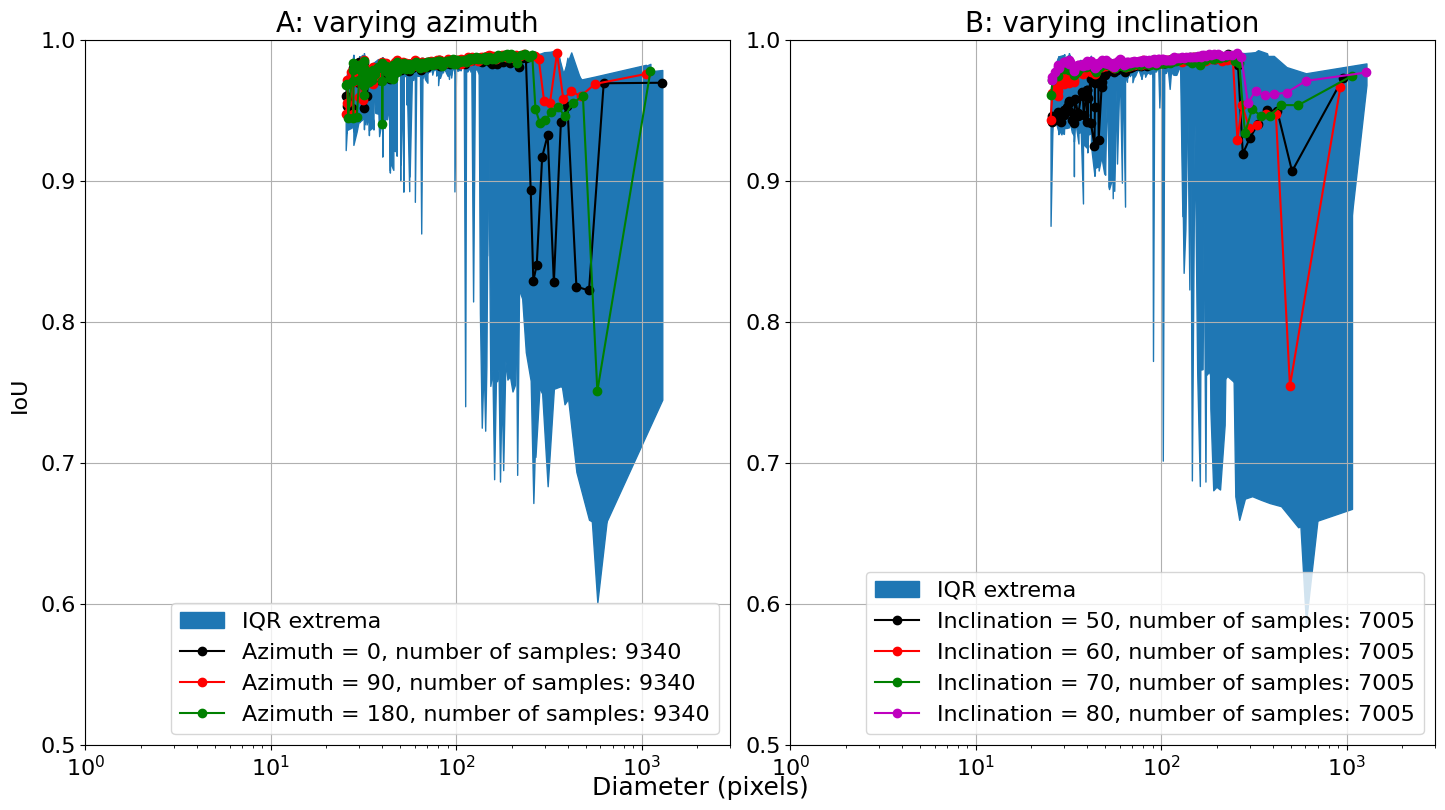

In [76]:
def binned_iou_median_IQR(DS_pths_list, title_label, color, bin_size=100):
    all_area = []
    all_iou = []

    for pth in DS_pths_list:
        d = np.load(pth, allow_pickle=True).item()
        area = np.array(d.get('area'))
        iou = np.abs(np.array(d.get('iou')))

        valid = iou > 0
        all_area.append(np.log10(area[valid]))
        all_iou.append(iou[valid])

    area = np.concatenate(all_area)
    iou = np.concatenate(all_iou)

    # Sort by area for consistent binning
    sort_idx = np.argsort(area)
    area = area[sort_idx]
    iou = iou[sort_idx]

    iou_median = []
    iou_upperIQR = []
    iou_lowerIQR = []
    bin_centers = []
    num_bins = len(area) // bin_size

    for n in range(num_bins):
        start_idx = n * bin_size
        end_idx = start_idx + bin_size if n < num_bins - 1 else len(area)
        bin_iou = iou[start_idx:end_idx]
        bin_area = area[start_idx:end_idx]

        iou_median.append(np.median(bin_iou))
        iou_upperIQR.append(np.percentile(bin_iou, 75))
        iou_lowerIQR.append(np.percentile(bin_iou, 25))
        bin_centers.append(np.mean(bin_area))

    bin_centers = [(np.sqrt(10 ** c / np.pi) / 0.2) * 2 for c in bin_centers]
    total_samples = sum([len(np.load(p, allow_pickle=True).item()['area']) for p in DS_pths_list])
    return bin_centers, iou_upperIQR, iou_lowerIQR, iou_median, total_samples

def DSL_binned_iou_median_IQR(DS, label_L, cl, bin_size=100):
    stack_area,stack_median, list_num_sample=[],[],[]

    for i in range(len(DS)):
        ds_area,UIQR,LIQR,median, num_sample=binned_iou_median_IQR(DS[i], label_L[i], cl[i], bin_size)
        
        stack_area.append(ds_area)
        stack_median.append(median)
        list_num_sample.append(num_sample)
        #upperIQR.append(UIQR)
        #lowerIQR.append(LIQR)
        plt.fill_between(ds_area,LIQR, UIQR, color='tab:blue', alpha=1, label='IQR extrema')
    for i in range(len(DS)):
        plt.plot(stack_area[i], stack_median[i], '-o', label=label_L[i]+f', number of samples: {list_num_sample[i]}', color=cl[i])
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.xlabel('Diameter (pixels)', fontsize=18)
    plt.ylim(0.5, 1)
    plt.xlim(1, 3000)
    plt.xscale('log')
    plt.ylabel('IoU', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid()
    plt.legend(handles=handles[-len(DS)-1:],loc='lower right', fontsize=16)
DS=[s02[0:4], s02[4:8], s02[8:12]]
cl=['k','r','g','m','b','c']
label_L=['Azimuth = 0','Azimuth = 90','Azimuth = 180']

plt.figure(figsize=(15, 8))
bin_size=50
plt.subplot(1,2,1)
DSL_binned_iou_median_IQR(DS, label_L, cl, bin_size=bin_size)
plt.title('A: varying azimuth', fontsize=20)
plt.xlabel('')
plt.ylabel('')
#plt.title(f'Median IoU binned by number of samples (shaded area: IQR), bin size = {bin_size}')

DS=[[s02[i+n] for i in [0, 4, 8]] for n in range(4)]
cl=['k','r','g','m']
label_L=['Inclination = 50','Inclination = 60','Inclination = 70','Inclination = 80']
plt.subplot(1,2,2)
DSL_binned_iou_median_IQR(DS, label_L, cl, bin_size=bin_size)
plt.title('B: varying inclination', fontsize=20)
plt.ylabel('')
plt.xlabel('')

plt.figtext(0.5, 0.0, 'Diameter (pixels)', ha='center', fontsize=18)
plt.gcf().text(0.04, 0.5, 'IoU', fontsize=16, rotation=90, va='center')
plt.tight_layout(rect=[0.05, 0, 1, 1])
#plt.savefig('figure/meadian_binned_iou_bw_b100.png')
plt.show()

In [75]:
int(s02[1][-6:-4])

1

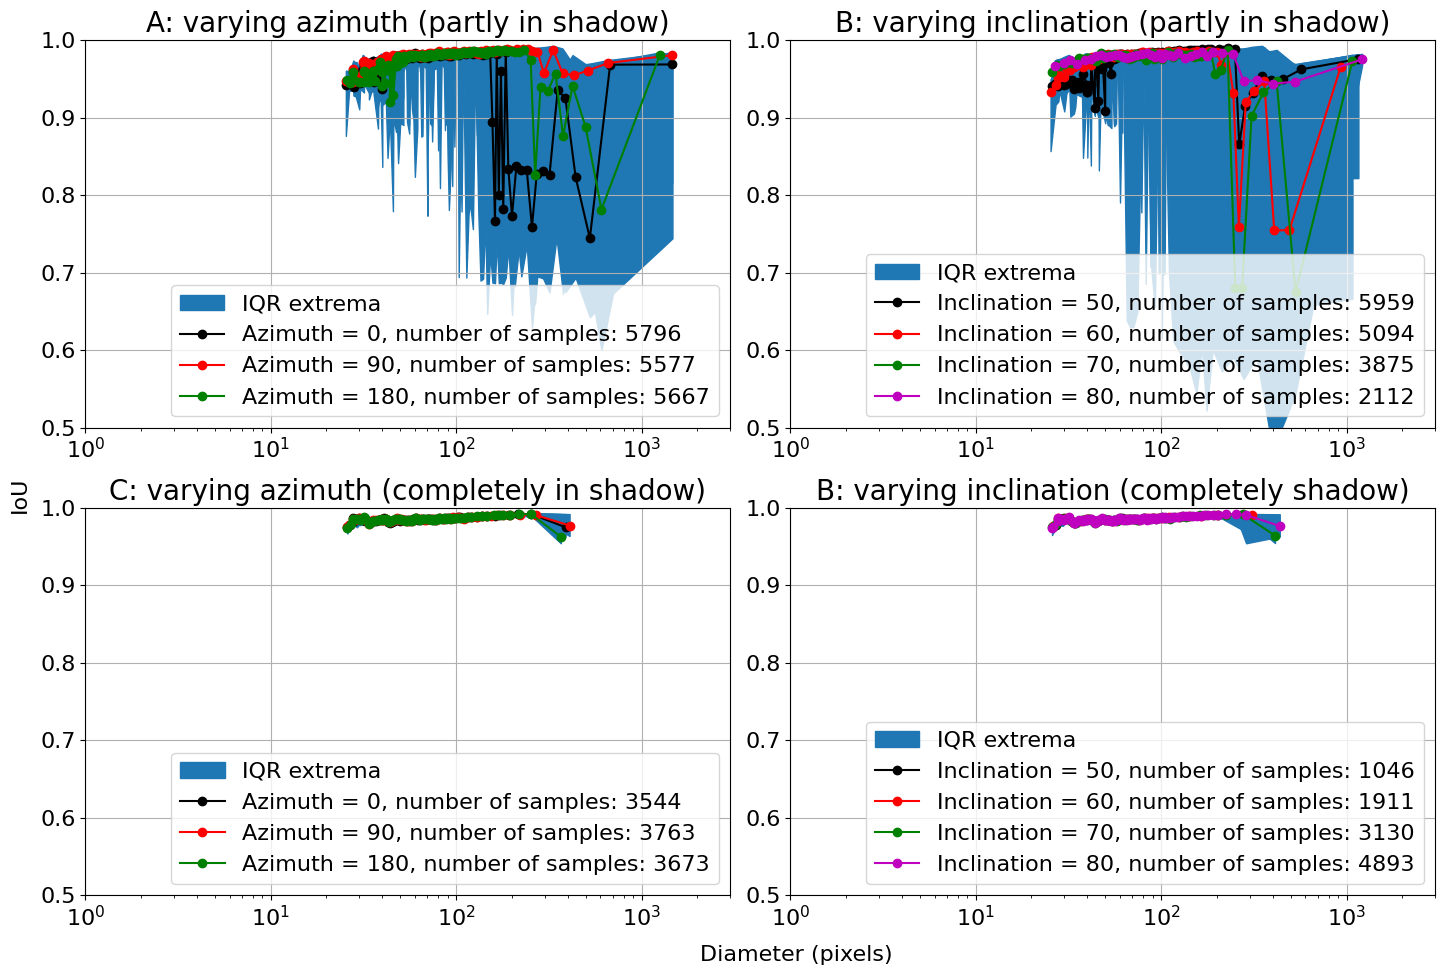

In [79]:
def binned_iou_median_IQR(DS_pths_list, title_label, color,shadow, bin_size=100):
    all_area = []
    all_iou = []
    num_L=[]

    for pth in DS_pths_list:
        d = np.load(pth, allow_pickle=True).item()
        area = np.array(d.get('area'))
        iou = np.abs(np.array(d.get('iou')))
        pth_id = int(pth[-6:-4])
        area=area[all_shadow_array[pth_id]==shadow]
        iou=iou[all_shadow_array[pth_id]==shadow]
        num=len(area)
        num_L.append(num)

        valid = iou > 0
        all_area.append(np.log10(area[valid]))
        all_iou.append(iou[valid])

    area = np.concatenate(all_area)
    iou = np.concatenate(all_iou)

    # Sort by area for consistent binning
    sort_idx = np.argsort(area)
    area = area[sort_idx]
    iou = iou[sort_idx]

    iou_median = []
    iou_upperIQR = []
    iou_lowerIQR = []
    bin_centers = []
    num_bins = len(area) // bin_size

    for n in range(num_bins):
        start_idx = n * bin_size
        end_idx = start_idx + bin_size if n < num_bins - 1 else len(area)
        bin_iou = iou[start_idx:end_idx]
        bin_area = area[start_idx:end_idx]

        iou_median.append(np.median(bin_iou))
        iou_upperIQR.append(np.percentile(bin_iou, 75))
        iou_lowerIQR.append(np.percentile(bin_iou, 25))
        bin_centers.append(np.mean(bin_area))

    bin_centers = [(np.sqrt(10 ** c / np.pi) / 0.2) * 2 for c in bin_centers]
    total_samples = sum(num_L)
    return bin_centers, iou_upperIQR, iou_lowerIQR, iou_median, total_samples

def DSL_binned_iou_median_IQR(DS, label_L, cl, shadow, bin_size=100):
    stack_area,stack_median, list_num_sample=[],[],[]

    for i in range(len(DS)):
        ds_area,UIQR,LIQR,median, num_sample=binned_iou_median_IQR(DS[i], label_L[i], cl[i], shadow, bin_size)
        
        stack_area.append(ds_area)
        stack_median.append(median)
        list_num_sample.append(num_sample)
        #upperIQR.append(UIQR)
        #lowerIQR.append(LIQR)
        plt.fill_between(ds_area,LIQR, UIQR, color='tab:blue', alpha=1, label='IQR extrema')
    for i in range(len(DS)):
        plt.plot(stack_area[i], stack_median[i], '-o', label=label_L[i]+f', number of samples: {list_num_sample[i]}', color=cl[i])
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.xlabel('Diameter (pixels)', fontsize=18)
    plt.ylim(0.5, 1)
    plt.xlim(1, 3000)
    plt.xscale('log')
    plt.ylabel('IoU', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid()
    plt.legend(handles=handles[-len(DS)-1:],loc='lower right', fontsize=16)
DS=[s02[0:4], s02[4:8], s02[8:12]]
cl=['k','r','g','m','b','c']
label_L=['Azimuth = 0','Azimuth = 90','Azimuth = 180']

plt.figure(figsize=(15, 10))
bin_size=50
plt.subplot(2,2,1)
DSL_binned_iou_median_IQR(DS, label_L, cl,0, bin_size=bin_size)
plt.title('A: varying azimuth (partly in shadow)', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2,2,3)
DSL_binned_iou_median_IQR(DS, label_L, cl,1, bin_size=bin_size)
plt.title('C: varying azimuth (completely in shadow)', fontsize=20)
plt.xlabel('')
plt.ylabel('')


DS=[[s02[i+n] for i in [0, 4, 8]] for n in range(4)]
cl=['k','r','g','m']
label_L=['Inclination = 50','Inclination = 60','Inclination = 70','Inclination = 80']
plt.subplot(2,2,2)
DSL_binned_iou_median_IQR(DS, label_L, cl, 0, bin_size=bin_size)
plt.title('B: varying inclination (partly in shadow)', fontsize=20)
plt.ylabel('')
plt.xlabel('')

DS=[[s02[i+n] for i in [0, 4, 8]] for n in range(4)]
cl=['k','r','g','m']
label_L=['Inclination = 50','Inclination = 60','Inclination = 70','Inclination = 80']
plt.subplot(2,2,4)
DSL_binned_iou_median_IQR(DS, label_L, cl, 1, bin_size=bin_size)
plt.title('B: varying inclination (completely shadow)', fontsize=20)
plt.ylabel('')
plt.xlabel('')

plt.gcf().text(0.04, 0.5, 'IoU', fontsize=16, rotation=90, va='center')
plt.gcf().text(0.5, 0.04, 'Diameter (pixels)', fontsize=16, va='center')

plt.tight_layout(rect=[0.05, 0.05, 1, 1])
#plt.savefig('figure/meadian_binned_iou_bw_b100.png')
plt.show()

C:\Users\Vito\AppData\Local\Temp\ipykernel_20280\146273341.py:38: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if c < len(ac_class):


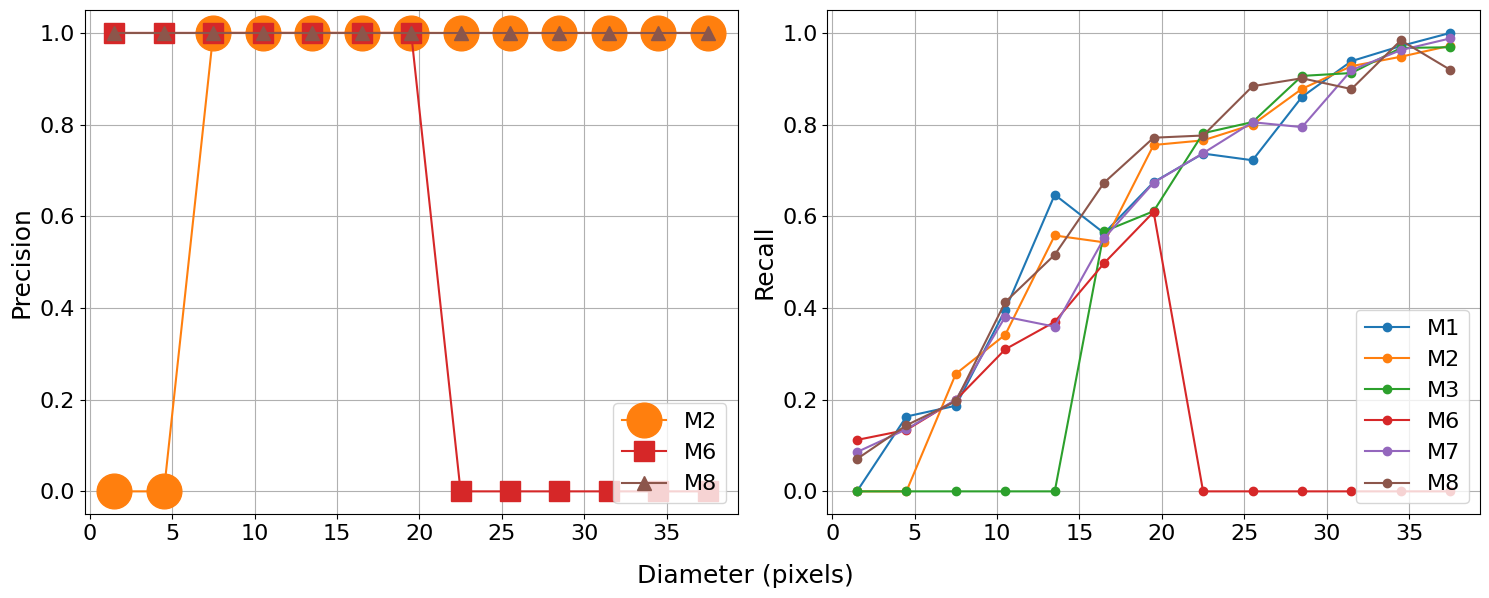

In [69]:
syn = rs02_3000  # Change this to focus on a different rs dataset

# Define diameter bins
bin_edges = np.arange(0, 40, 3)  # Bins from 0 to 20 in steps of 2
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

Min_radi=['M1','M2','M3','M6','M7','M8']
sym=['-','o-','-','s-','-','^-']
ms=[0,25,0,15,0,10]
fig, ax =plt.subplots(1,2,figsize=(15, 6))
precision_L, recall_L = [], []
for l,syn in enumerate([rs02_3000, rs04_3000, rs08, rs01_10, rs01_100, rs01_1000]):
    precision_binned = []
    recall_binned = []

    for i in range(len(bin_edges) - 1):
        TP_T, FP_T, FN_T = 0, 0, 0  
    
        for pth in syn:
            ran = np.load(pth, allow_pickle=True)
            area = np.array(ran.item().get('area'))
            area = (np.sqrt(area / np.pi) / 0.2) * 2  
            ac = np.array(ran.item().get('point based'))

            mask = (area >= bin_edges[i]) & (area < bin_edges[i + 1])
            ac_bin = ac[mask]
            area_bin = area[mask]

            if len(area_bin) == 0:
                continue 

            ac_class, count = np.unique(ac_bin, return_counts=True)

            TP_count = np.sum(count[ac_class > 0]) if 1 in ac_class else 0
            FN_count = count[ac_class == 0][0] if 0 in ac_class else 0
            multi = 0
            for c in np.where(ac_class > 1):
                if c < len(ac_class):
                    multi += (count[c] * ac_class[c]).item()
            FP_count = multi - np.sum(count[ac_class > 1])

            TP_T += TP_count
            FN_T += FN_count
            FP_T += FP_count

        precision = TP_T / (TP_T + FP_T) if (TP_T + FP_T) > 0 else 0
        recall = TP_T / (TP_T + FN_T) if (TP_T + FN_T) > 0 else 0

        precision_binned.append(precision)
        recall_binned.append(recall)

    # Plot the binned precision and recall
    if l%2 == 1:
        ax[0].plot(bin_centers, precision_binned,sym[l], label=f'{Min_radi[l]}', markersize=ms[l])#'$r_{min}$'+f' = {Min_radi[l]}'
    else:
        ax[0].plot([],[])
    ax[1].plot(bin_centers, recall_binned, 'o-', label=f'{Min_radi[l]}')
ax[1].legend(loc='lower right', fontsize=16)
ax[0].legend(loc='lower right', fontsize=16)
ax[0].grid()
ax[1].grid()
#ax[0].set_title('A: Precision', fontsize=20)
#ax[0].set_title('B: Recall', fontsize=20)
ax[0].tick_params(axis='both', labelsize=16)
ax[1].tick_params(axis='both', labelsize=16)
#plt.xlabel('Diameter (pixels)', fontsize=16)
ax[0].set_ylabel('Precision', fontsize=18)
ax[1].set_ylabel('Recall', fontsize=18)
plt.figtext(0.5, 0.01, 'Diameter (pixels)', ha='center', fontsize=18)
plt.tight_layout(rect=[0,0.05,1,0.99])
plt.savefig('figure\detection_limit.png')
plt.show()

C:\Users\Vito\AppData\Local\Temp\ipykernel_20280\1959849682.py:38: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if c < len(ac_class):
C:\Users\Vito\AppData\Local\Temp\ipykernel_20280\1959849682.py:88: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if c < len(ac_class):


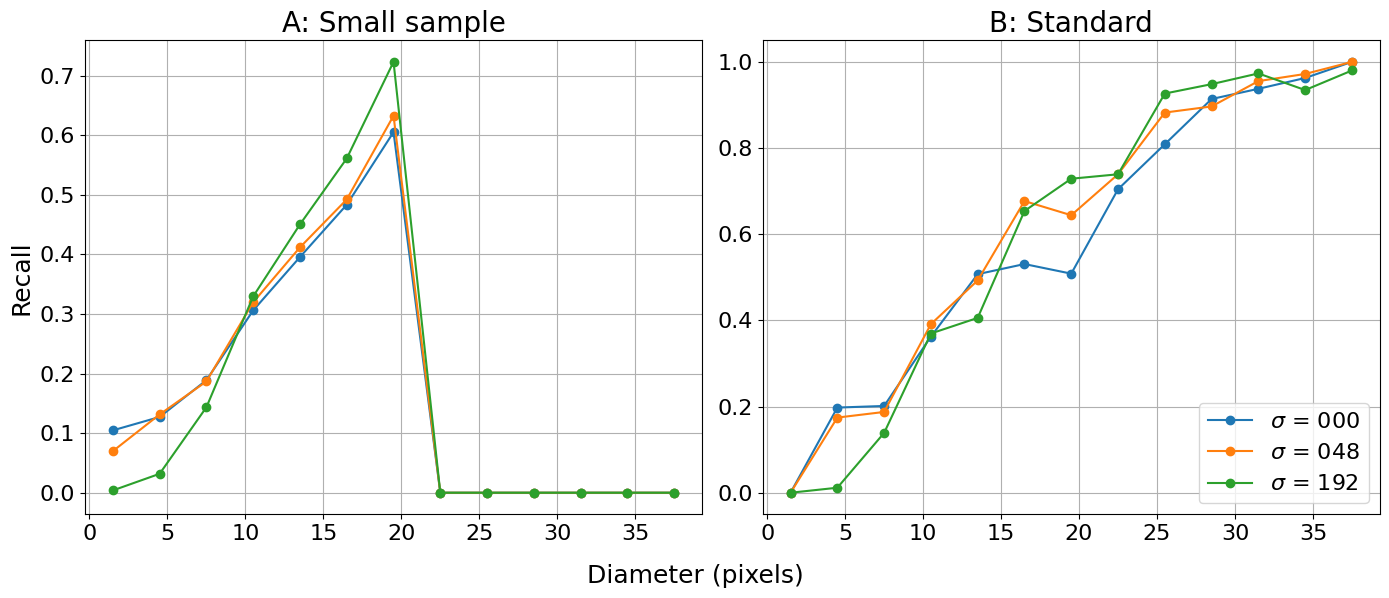

In [55]:
bin_edges = np.arange(0, 40, 3)  # Bins from 0 to 20 in steps of 2
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

#Min_radi=['000','003','012','024','048','096','128','192']
fig, ax =plt.subplots(1,2,figsize=(14, 6))
#precision_L, recall_L = [], []
#noise=[0,3,12,24,48,96,128,192]
#for l,syn in enumerate([cl00_10, cl03_10, cl12_10, cl24_10, cl48_10, cl96_10, cl128_10, cl192_10]):
Min_radi=['000','048','192']
precision_L, recall_L = [], []
noise=[0,48,192]
for l,syn in enumerate([cl00_10, cl48_10, cl192_10]):
    precision_binned = []
    recall_binned = []

    for i in range(len(bin_edges) - 1):
        TP_T, FP_T, FN_T = 0, 0, 0  
    
        for pth in syn:
            ran = np.load(pth, allow_pickle=True)
            area = np.array(ran.item().get('area'))
            area = (np.sqrt(area / np.pi) / 0.2) * 2  
            ac = np.array(ran.item().get('point based'))

            mask = (area >= bin_edges[i]) & (area < bin_edges[i + 1])
            ac_bin = ac[mask]
            area_bin = area[mask]

            if len(area_bin) == 0:
                continue 

            ac_class, count = np.unique(ac_bin, return_counts=True)

            TP_count = np.sum(count[ac_class > 0]) if 1 in ac_class else 0
            FN_count = count[ac_class == 0][0] if 0 in ac_class else 0
            multi = 0
            for c in np.where(ac_class > 1):
                if c < len(ac_class):
                    multi += (count[c] * ac_class[c]).item()
            FP_count = multi - np.sum(count[ac_class > 1])

            TP_T += TP_count
            FN_T += FN_count
            FP_T += FP_count

        precision = TP_T / (TP_T + FP_T) if (TP_T + FP_T) > 0 else 0
        recall = TP_T / (TP_T + FN_T) if (TP_T + FN_T) > 0 else 0

        precision_binned.append(precision)
        recall_binned.append(recall)

    # Plot the binned precision and recall
    ax[0].plot(bin_centers, recall_binned, 'o-', label=r'$\sigma$ = '+f'{Min_radi[l]}')
ax[0].tick_params(labelsize=16) 
#Min_radi=['000','003','012','024','048','096','128','192']
#precision_L, recall_L = [], []
#noise=[0,3,12,24,48,96,128,192]
#for l,syn in enumerate([cl00_02, cl03_02, cl12_02, cl24_02, cl48_02, cl96_02, cl128_02, cl192_02]):
Min_radi=['000','048','192']
precision_L, recall_L = [], []
noise=[0,48,192]
for l,syn in enumerate([cl00_02, cl48_02, cl192_02]):
    precision_binned = []
    recall_binned = []

    for i in range(len(bin_edges) - 1):
        TP_T, FP_T, FN_T = 0, 0, 0  
    
        for pth in syn:
            ran = np.load(pth, allow_pickle=True)
            area = np.array(ran.item().get('area'))
            area = (np.sqrt(area / np.pi) / 0.2) * 2  
            ac = np.array(ran.item().get('point based'))

            mask = (area >= bin_edges[i]) & (area < bin_edges[i + 1])
            ac_bin = ac[mask]
            area_bin = area[mask]

            if len(area_bin) == 0:
                continue 

            ac_class, count = np.unique(ac_bin, return_counts=True)

            TP_count = np.sum(count[ac_class > 0]) if 1 in ac_class else 0
            FN_count = count[ac_class == 0][0] if 0 in ac_class else 0
            multi = 0
            for c in np.where(ac_class > 1):
                if c < len(ac_class):
                    multi += (count[c] * ac_class[c]).item()
            FP_count = multi - np.sum(count[ac_class > 1])

            TP_T += TP_count
            FN_T += FN_count
            FP_T += FP_count

        precision = TP_T / (TP_T + FP_T) if (TP_T + FP_T) > 0 else 0
        recall = TP_T / (TP_T + FN_T) if (TP_T + FN_T) > 0 else 0

        precision_binned.append(precision)
        recall_binned.append(recall)

    # Plot the binned precision and recall
    #ax[0].plot(bin_centers, precision_binned, 'o-', label=f'{Min_radi[l]}')#'$r_{min}$'+f' = {Min_radi[l]}'
    ax[1].plot(bin_centers, recall_binned, 'o-', label=r'$\sigma$ = '+f'{Min_radi[l]}')
#ax[0].legend(loc='lower right', fontsize=12)
ax[1].legend(loc='lower right', fontsize=16)
ax[0].grid()
ax[1].grid()
ax[0].set_title('A: Small sample', fontsize=20)
ax[1].set_title('B: Standard', fontsize=20)
#plt.xticks(fontsize=16)
#plt.yticks(fontsize=16)
ax[1].tick_params(labelsize=16) 
#plt.xlabel('Diameter (pixels)', fontsize=16)
ax[0].set_ylabel('Recall', fontsize=18)
plt.figtext(0.5, 0.01, 'Diameter (pixels)', ha='center', fontsize=18)
plt.tight_layout(rect=[0,0.05,1,0.99])
plt.savefig('figure\sigma_recall_noise.png')
plt.show()

In [ ]:
def ks_DS(DS_pths):
    sizes=[]
    sizes_re=[]
    for pth in DS_pths:
        ran=np.load(pth, allow_pickle=True)
        sizes += list(ran.item().get('area'))
        sizes_re += list(ran.item().get('segment area'))
    
    sizes = np.sort(sizes)/(0.2*0.2)

    sizes_re = np.sort(sizes_re)

    ks=ks_2samp(sizes_re,sizes, method= 'exact', alternative='two-sided')
    return ks
def cdf(DS_pths, title_label, result=True):
    sizes=[]
    sizes_re=[]
    for pth in DS_pths:
        ran=np.load(pth, allow_pickle=True)
        sizes += list(ran.item().get('area'))
        
        if result:
            sizes_re += list(ran.item().get('segment area'))
    
    sizes = np.sort(sizes)/(0.2*0.2)
    cdf = np.arange(1, len(sizes) + 1) / len(sizes)
    plt.plot(sizes, cdf, linestyle="-", label='Label')
    plt.title(title_label, fontsize=20)
    if result:
        sizes_re = np.sort(sizes_re)
        cdf_re = np.arange(1, len(sizes_re) + 1) / len(sizes_re)
        plt.plot(sizes_re, cdf_re, linestyle="--", label='tile SAM')
        ks_test=ks_DS(DS_pths)
        plt.title(title_label+'\n'+fr'K-S $D$: {np.round(ks_test[0],2):.2}, $p$: {np.round(ks_test[1],2):.2}'+'\n'+fr'$n_l$: {len(sizes)}, $n_s$: {len(sizes_re)}', fontsize=20)

    
    plt.xscale("log")
    plt.xlabel("Area (pixels)", fontsize=18)
    plt.ylabel("Cumulative Probability", fontsize=18) 
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)       
    plt.grid(True)

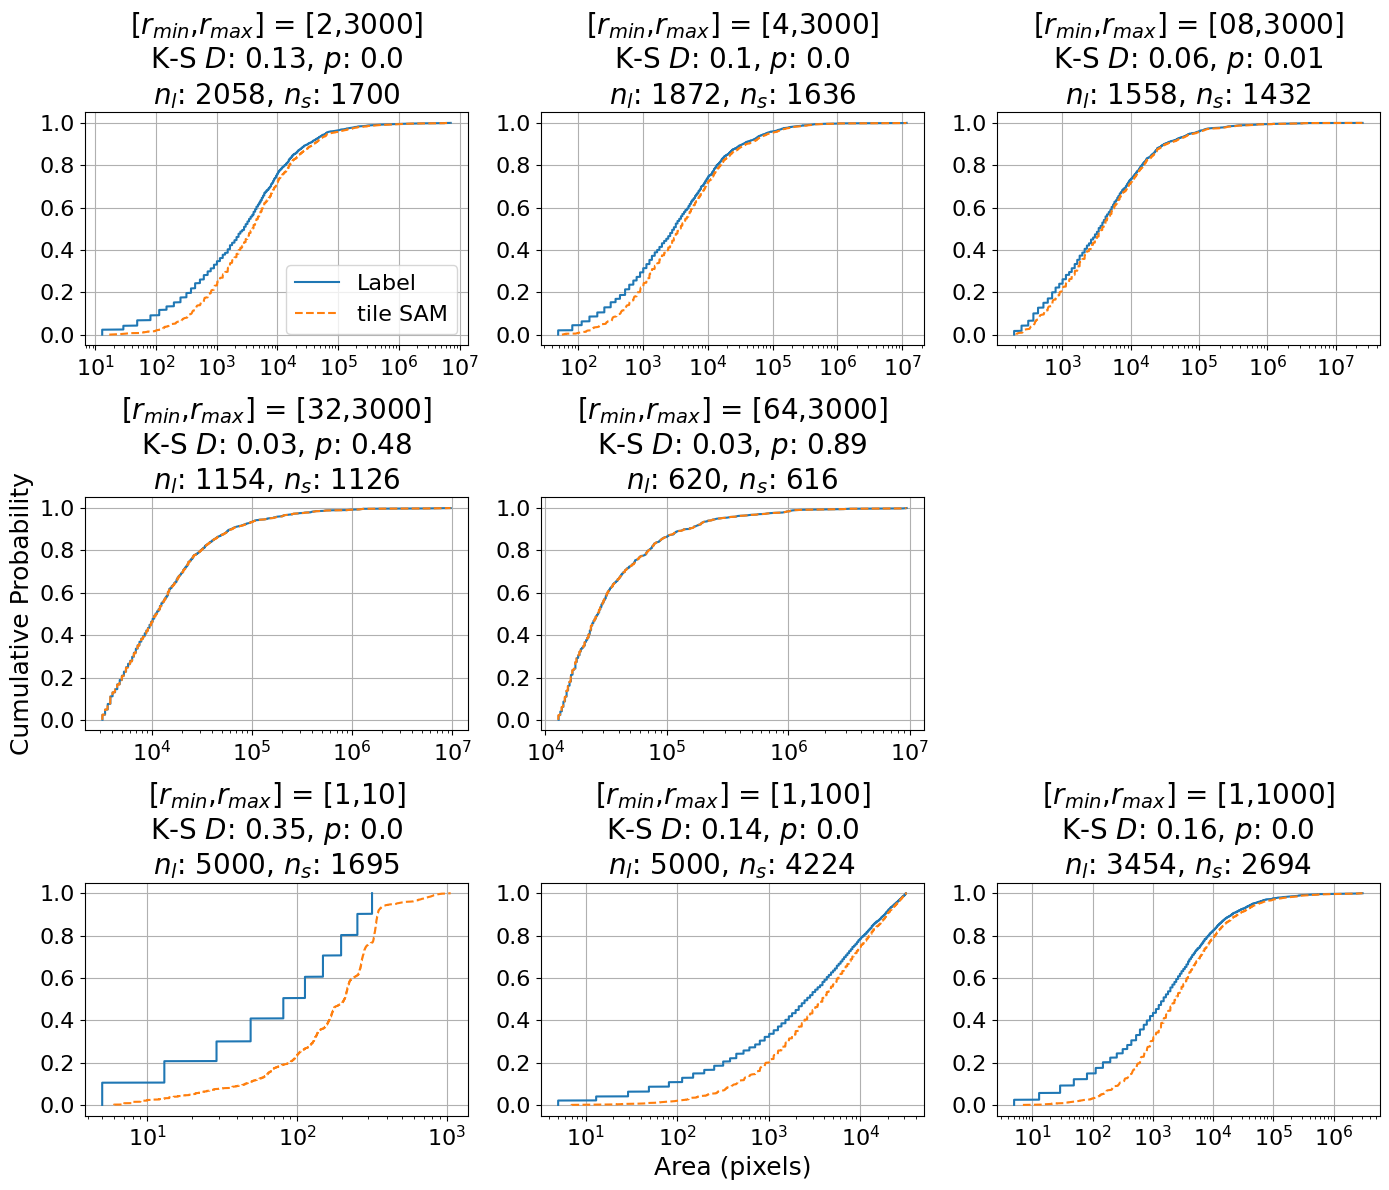

In [28]:

plt.figure(figsize=(14,12))
plt.subplot(3,3,1)
cdf(rs02_3000, r"[$r_{min}$,$r_{max}$] = [2,3000]")
plt.xlabel('')
plt.ylabel('')
plt.legend(fontsize=16)
plt.subplot(3,3,2)
cdf(rs04_3000, r"[$r_{min}$,$r_{max}$] = [4,3000]")
plt.xlabel('')
plt.ylabel('')
plt.subplot(3,3,3)
cdf(rs08, r"[$r_{min}$,$r_{max}$] = [08,3000]")
plt.xlabel('')
plt.ylabel('')
plt.subplot(3,3,4)
cdf(rs32, r"[$r_{min}$,$r_{max}$] = [32,3000]")
plt.xlabel('')
plt.subplot(3,3,5)
cdf(rs64, r"[$r_{min}$,$r_{max}$] = [64,3000]")
plt.xlabel('')
plt.ylabel('')
plt.subplot(3,3,7)
cdf(rs01_10, r"[$r_{min}$,$r_{max}$] = [1,10]")
plt.xlabel('')
plt.ylabel('')
plt.subplot(3,3,8)
cdf(rs01_100, r"[$r_{min}$,$r_{max}$] = [1,100]")
#plt.xlabel('')
plt.ylabel('')
plt.subplot(3,3,9)
cdf(rs01_1000, r"[$r_{min}$,$r_{max}$] = [1,1000]")
plt.ylabel('')
plt.xlabel('')
#plt.subplot(3,3,9)
#cdf(rs08_100, "Radii: 08-100")
#plt.xlabel('')
#plt.ylabel('')
#plt.suptitle("Size distribution of synthetic scene")
plt.tight_layout()
plt.savefig('C:/Users/Vito/Documents/MasterThesis/figure/size_dist_synth_b100.png')

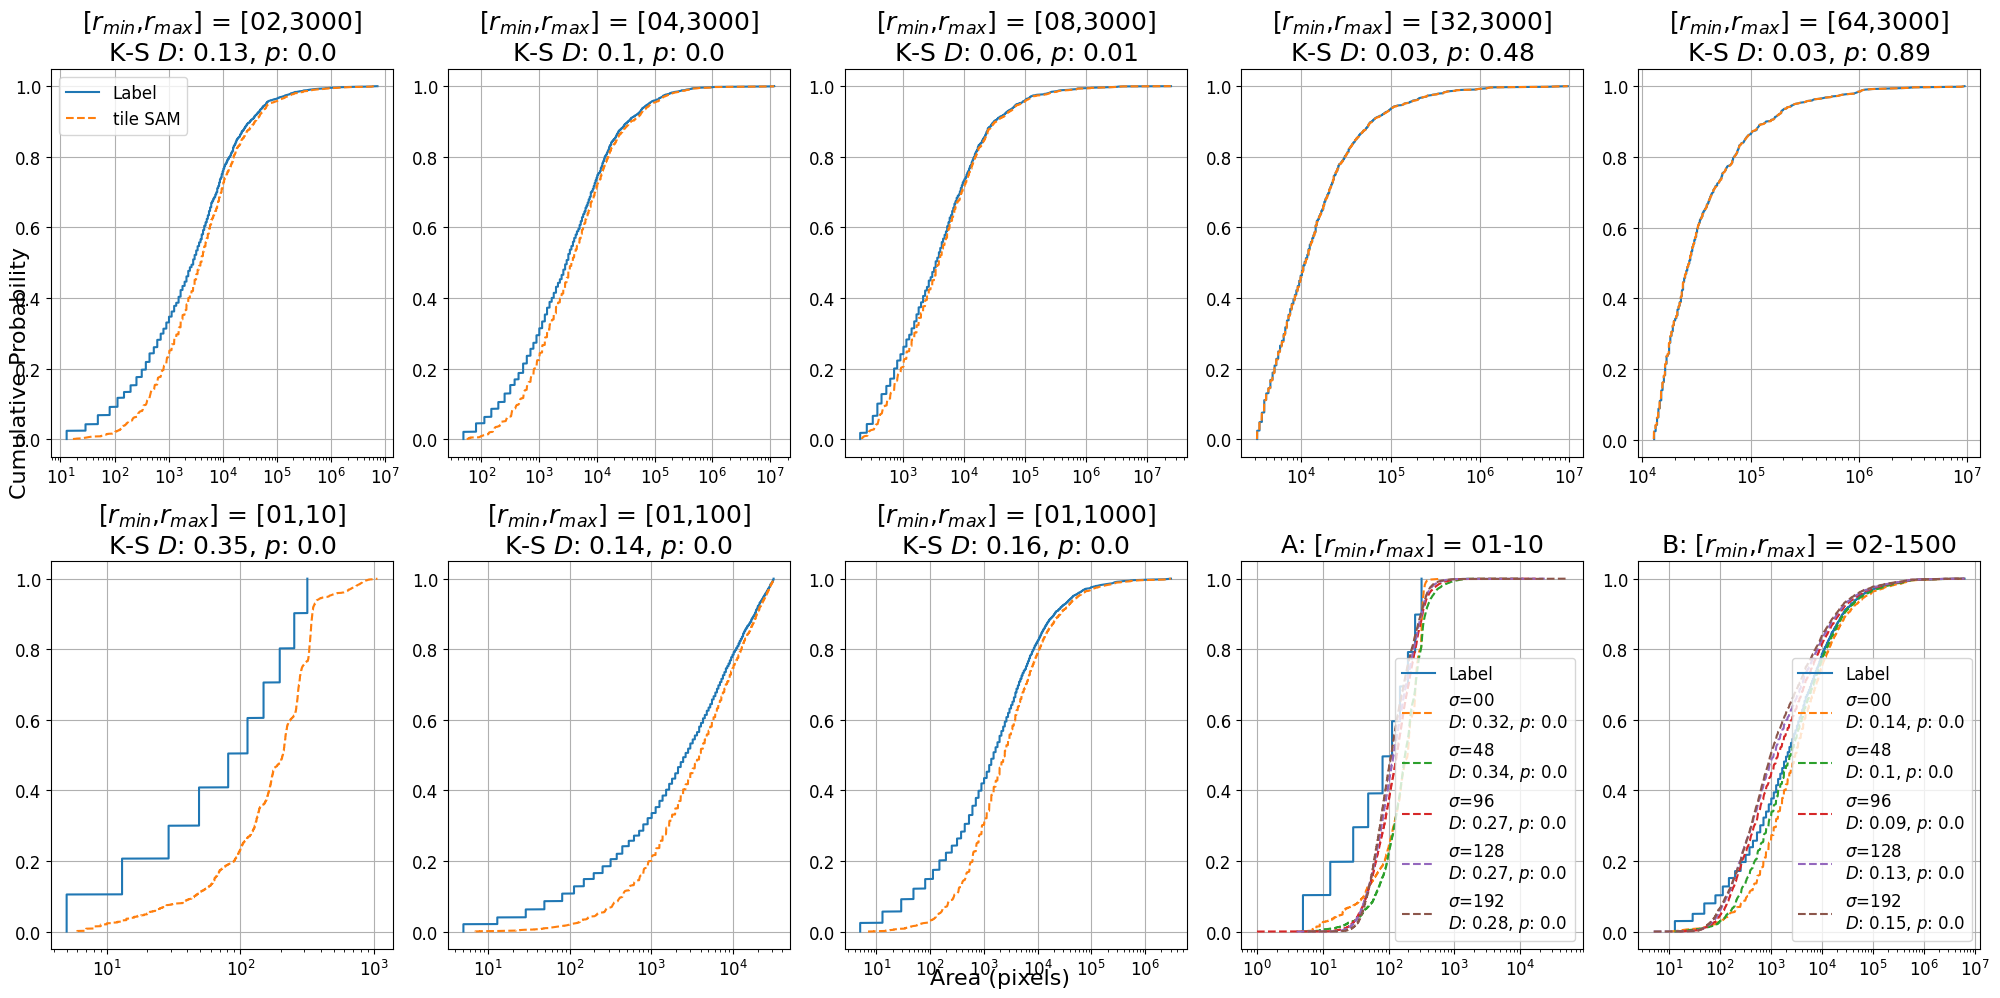

In [184]:
plt.figure(figsize=(20,10))
plt.subplot(2,5,1)
cdf(rs02_3000, r"[$r_{min}$,$r_{max}$] = [02,3000]")
plt.xlabel('')
plt.ylabel('')
plt.legend(fontsize=12)
plt.subplot(2,5,2)
cdf(rs04_3000, r"[$r_{min}$,$r_{max}$] = [04,3000]")
plt.xlabel('')
plt.ylabel('')
plt.subplot(2,5,3)
cdf(rs08, r"[$r_{min}$,$r_{max}$] = [08,3000]")
plt.xlabel('')
plt.ylabel('')
plt.subplot(2,5,4)
cdf(rs32, r"[$r_{min}$,$r_{max}$] = [32,3000]")
plt.xlabel('')
plt.ylabel('')
plt.subplot(2,5,5)
cdf(rs64, r"[$r_{min}$,$r_{max}$] = [64,3000]")
plt.xlabel('')
plt.ylabel('')
plt.subplot(2,5,6)
cdf(rs01_10, r"[$r_{min}$,$r_{max}$] = [01,10]")
plt.xlabel('')
plt.ylabel('')
plt.subplot(2,5,7)
cdf(rs01_100, r"[$r_{min}$,$r_{max}$] = [01,100]")
plt.xlabel('')
plt.ylabel('')
plt.subplot(2,5,8)
cdf(rs01_1000, r"[$r_{min}$,$r_{max}$] = [01,1000]")
plt.ylabel('')
plt.xlabel('')
plt.subplot(2,5,9)
plt.title(r"A: [$r_{min}$,$r_{max}$] = 01-10", fontsize=18)
cdf_cl(cl00_10, r'$\sigma$=00',True)
cdf_cl(cl48_10, r'$\sigma$=48')
cdf_cl(cl96_10, r'$\sigma$=96')
cdf_cl(cl128_10, r'$\sigma$=128')
cdf_cl(cl192_10, r'$\sigma$=192')
plt.legend(fontsize=12)

    
plt.xscale("log")
#plt.xlabel("Area (pixels)", fontsize=16)
#plt.ylabel("Cumulative Probability", fontsize=16) 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)       
plt.grid(True)

plt.subplot(2,5,10)
plt.title(r"B: [$r_{min}$,$r_{max}$] = 02-1500", fontsize=18)
cdf_cl(cl00_02, r'$\sigma$=00',True)
cdf_cl(cl48_02, r'$\sigma$=48')
cdf_cl(cl96_02, r'$\sigma$=96')
cdf_cl(cl128_02, r'$\sigma$=128')
cdf_cl(cl192_02, r'$\sigma$=192')
plt.xscale("log")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)       
plt.grid(True)
#plt.xlabel("Area (pixels)", fontsize=16)
plt.figtext(0.5, 0.01, 'Area (pixels)', ha='center', fontsize=16)
plt.figtext(0.01, 0.5, 'Cumulative Probability', rotation='vertical',ha='center', fontsize=16)
plt.tight_layout()

In [93]:
def average_iou(DS_pths):
    d=np.load(DS_pths, allow_pickle=True)
    area=d.item().get('area')
    iou=np.abs(d.item().get('iou'))

    #area = np.log10(area)

    area=area[iou>0]
    iou=iou[iou>0]
    meaniou=np.mean(iou)
    iou=iou[area>(np.pi*15*15/(0.2*0.2))]
    if len(iou)>0:
        meaniou_t=np.mean(iou)
    else:
        meaniou_t=0
    print(f'mean iou: {meaniou}, mean iou t: {meaniou_t}')
    return meaniou
all_mean=[]
for DS in [rs02_3000, rs04_3000,rs08, rs32, rs64,rs01_10, rs01_100, rs01_1000]:
    all_mean.append(average_iou(DS[0]))



mean iou: 0.9743368883604733, mean iou t: 0.9877492718757284
mean iou: 0.9771550402012432, mean iou t: 0.979086638103541
mean iou: 0.9844455508638809, mean iou t: 0.9879137688033965
mean iou: 0.9926668461600806, mean iou t: 0.98932270529384
mean iou: 0.9908231843863191, mean iou t: 0.9861053096769627
mean iou: 0.8124967876027446, mean iou t: 0
mean iou: 0.9779090141381215, mean iou t: 0
mean iou: 0.9689146038065277, mean iou t: 0.9867331797112001
